In [46]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance

import numpy as np
import matplotlib.pyplot as plt
import warnings
import time

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None

# For parallel processing (-1 means use all cores, None means 1 core)
PARALLEL = 10

# Load the data
train = pd.read_csv('../data/preprocessed/prp_combined_Y1.csv')
test = pd.read_csv('../data/preprocessed/prp_combined_Y2.csv')

# Segment data
Y_train = train['DaysInHospitalY2']
X_train = train.drop(columns=['DaysInHospitalY2', 'MemberID'])
Y_test = test['DaysInHospitalY3']
X_test = test.drop(columns=['DaysInHospitalY3', 'MemberID'])

## **Random Forests Classifier**
This notebook utilises a Random Forests Classifier to determine `DaysInHospital`. The problem is modelled as a classification task with 16 classes (0 - 15).
Hyperparameters are tested using a custom implementation of random search hyperparameter tuning (given the number of parameters, it would be infeasible to test using Grid Search), with the best estimator being selected via `roc_auc` score.
Stratified K-Fold is applied to preserve class distributions (important since dataset is imbalanced).

In [47]:
# Definitions and parameter initializations

# Stratified K-Fold
outer_split = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
inner_split = StratifiedKFold(n_splits=4)

# Hyperparameters
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Classifier
rfc = RandomForestClassifier()

# Number of random search samplings
N_ITER = 10

# Normalisation scaler
scaler = MinMaxScaler()

cv_scores = {
    'roc_auc': [],
    'f1': [],
    'precision': [],
    'recall': []
}

best_params = []

### **Cross Validation and Hyperparameter Tuning**

In [49]:
# Primary cross validation loop
i = 1
start = time.time()
print("Beginning cross validation loop")
for outer_train_idx, outer_test_idx in outer_split.split(X_train, Y_train):

    X_train_outer, X_test_outer = X_train.iloc[outer_train_idx], X_train.iloc[outer_test_idx]
    Y_train_outer, Y_test_outer = Y_train.iloc[outer_train_idx], Y_train.iloc[outer_test_idx]

    # Normalise length of stay within CV loop
    X_train_outer['LengthOfStay'] = scaler.fit_transform(X_train_outer[['LengthOfStay']])
    X_test_outer['LengthOfStay'] = scaler.transform(X_test_outer[['LengthOfStay']])

    # Hyperparameter tuning
    hyper_scoring = {
        'mean_roc_aucs': [],
        'params': []
    }
    # Sampling hyperparameters
    for k in range(N_ITER):
        #print(f"Inner sampling loop {k+1}")

        sum_roc_auc = 0
        params = {
            'n_estimators': param_grid['n_estimators'][np.random.randint(0, len(param_grid['n_estimators']))],
            'max_depth': param_grid['max_depth'][np.random.randint(0, len(param_grid['max_depth']))],
            'min_samples_split': param_grid['min_samples_split'][np.random.randint(0, len(param_grid['min_samples_split']))],
            'criterion': param_grid['criterion'][np.random.randint(0, len(param_grid['criterion']))]
        }

        # Secondary (inner) cross validation loop
        for inner_train_idx, inner_test_idx in inner_split.split(X_train_outer, Y_train_outer):
            X_train_inner, X_test_inner = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[inner_test_idx]
            Y_train_inner, Y_test_inner = Y_train_outer.iloc[inner_train_idx], Y_train_outer.iloc[inner_test_idx]

            rfc.set_params(**params)
            rfc.fit(X_train_inner, Y_train_inner)

            Y_pred_proba_inner = rfc.predict_proba(X_test_inner)
            sum_roc_auc += roc_auc_score(Y_test_inner, Y_pred_proba_inner, multi_class='ovr')

        hyper_scoring['mean_roc_aucs'].append(sum_roc_auc / inner_split.get_n_splits())
        hyper_scoring['params'].append(params)

    # Determine best estimator based on roc_auc
    best_hyper_params = hyper_scoring['params'][np.argmax(hyper_scoring['mean_roc_aucs'])]
    best_params.append(best_hyper_params)

    # Refit model with outer loop training data
    rfc.set_params(**best_hyper_params)
    rfc.fit(X_train_outer, Y_train_outer)

    Y_pred = rfc.predict(X_test_outer)
    Y_pred_proba = rfc.predict_proba(X_test_outer)

    # Calculate scores and save them
    cv_scores['roc_auc'].append(roc_auc_score(Y_test_outer, Y_pred_proba, multi_class='ovr'))
    cv_scores['precision'].append(precision_score(Y_test_outer, Y_pred, average='macro', zero_division=1))
    cv_scores['recall'].append(recall_score(Y_test_outer, Y_pred, average='macro', zero_division=1))
    cv_scores['f1'].append(f1_score(Y_test_outer, Y_pred, average='macro', zero_division=1))

    print(f"Outer loop {i}, time elapsed: {(time.time() - start) / 60:.2f} minutes")
    i += 1

Beginning cross validation loop
Outer loop 1, time elapsed: 2.04 minutes
Outer loop 2, time elapsed: 3.85 minutes
Outer loop 3, time elapsed: 5.98 minutes
Outer loop 4, time elapsed: 7.62 minutes
Outer loop 5, time elapsed: 9.66 minutes
Outer loop 6, time elapsed: 11.84 minutes
Outer loop 7, time elapsed: 13.06 minutes
Outer loop 8, time elapsed: 15.66 minutes
Outer loop 9, time elapsed: 18.37 minutes
Outer loop 10, time elapsed: 19.94 minutes
Outer loop 11, time elapsed: 21.49 minutes
Outer loop 12, time elapsed: 23.28 minutes
Outer loop 13, time elapsed: 25.66 minutes
Outer loop 14, time elapsed: 27.24 minutes
Outer loop 15, time elapsed: 29.89 minutes
Outer loop 16, time elapsed: 32.53 minutes
Outer loop 17, time elapsed: 34.96 minutes
Outer loop 18, time elapsed: 36.71 minutes
Outer loop 19, time elapsed: 38.44 minutes
Outer loop 20, time elapsed: 41.44 minutes


In [50]:
# Find the best estimator among best estimators using greatest roc_auc
hold_x_train, hold_x_test, hold_y_train, hold_y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

hold_x_train['LengthOfStay'] = scaler.fit_transform(hold_x_train[['LengthOfStay']])
hold_x_test['LengthOfStay'] = scaler.transform(hold_x_test[['LengthOfStay']])

best = {
    'best_roc_auc': 0,
    'best_estimator': None
}
for params in best_params:
    rfc.set_params(**params)
    rfc.fit(hold_x_train, hold_y_train)

    pred = rfc.predict(hold_x_test)
    pred_proba = rfc.predict_proba(hold_x_test)

    roc_auc = roc_auc_score(hold_y_test, pred_proba, multi_class='ovr')
    
    if best['best_roc_auc'] < roc_auc:
        best['best_roc_auc'] = roc_auc
        best['best_params'] = params

## **Results and Visuals Generation**

### **Final summary scores**

In [51]:
# Score final model and get predictions on test set
params = best['best_params']

rfc.set_params(**best['best_params'])

X_train['LengthOfStay'] = scaler.fit_transform(X_train[['LengthOfStay']])
X_test['LengthOfStay'] = scaler.transform(X_test[['LengthOfStay']])

rfc.fit(X_train, Y_train)

pred = rfc.predict(X_test)
pred_proba = rfc.predict_proba(X_test)

pred_train = rfc.predict(X_train)
pred_proba_train = rfc.predict_proba(X_train)

roc_auc = roc_auc_score(Y_test, pred_proba, multi_class='ovr')
precision = precision_score(Y_test, pred, average='macro', zero_division=1)
recall = recall_score(Y_test, pred, average='macro', zero_division=1)
f1 = f1_score(Y_test, pred, average='macro', zero_division=1)

roc_auc_train = roc_auc_score(Y_train, pred_proba_train, multi_class='ovr')
precision_train = precision_score(Y_train, pred_train, average='macro', zero_division=1)
recall_train = recall_score(Y_train, pred_train, average='macro', zero_division=1)
f1_train = f1_score(Y_train, pred_train, average='macro', zero_division=1)

print(f"ROC AUC Test: {roc_auc:.4f}")
print(f"Precision Test: {precision:.4f}")
print(f"Recall Test: {recall:.4f}")
print(f"F1 Test: {f1:.4f}")
print("------------------------------")
print(f"ROC AUC Train: {roc_auc_train:.4f}")
print(f"Precision Train: {precision_train:.4f}")
print(f"Recall Train: {recall_train:.4f}")
print(f"F1 Train: {f1_train:.4f}")


ROC AUC Test: 0.7487
Precision Test: 0.9906
Recall Test: 0.0625
F1 Test: 0.0574
------------------------------
ROC AUC Train: 0.7879
Precision Train: 0.9903
Recall Train: 0.0625
F1 Train: 0.0573


### **Cross Validation Summary Score Visualisation**

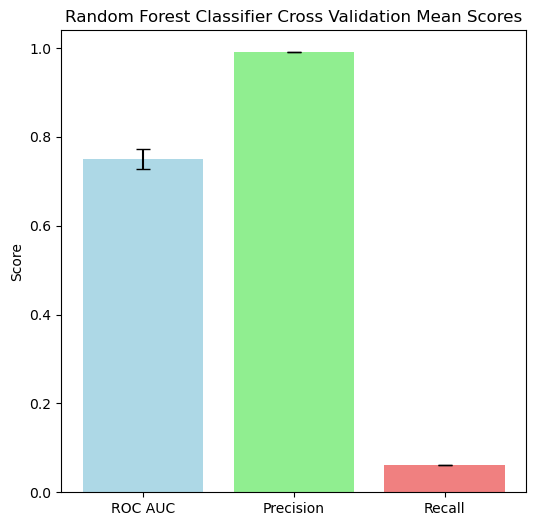

In [52]:
# Calculate standard deviations for scores
std_roc_auc = np.std(cv_scores['roc_auc'])
std_precision = np.std(cv_scores['precision'])
std_recall = np.std(cv_scores['recall'])
std_f1 = np.std(cv_scores['f1'])

stds = [std_roc_auc, std_precision, std_recall]

# Means of scores
mean_roc_auc = np.mean(cv_scores['roc_auc'])
mean_precision = np.mean(cv_scores['precision'])
mean_recall = np.mean(cv_scores['recall'])
mean_f1 = np.mean(cv_scores['f1'])

means = [mean_roc_auc, mean_precision, mean_recall]

colours = ['#ADD8E6', '#90EE90', '#F08080']

fig, ax = plt.subplots(figsize=(6, 6))
plt.bar(['ROC AUC', 'Precision', 'Recall'], means, yerr=stds, color=colours, capsize=5)
plt.ylabel('Score')
plt.title('Random Forest Classifier Cross Validation Mean Scores')
plt.show()


### **Permutation feature importance**

In [ ]:
# Permutation Feature Importance
res = permutation_importance(rfc, X_train, Y_train, n_repeats=50, random_state=42, n_jobs=PARALLEL)
feature_importance = pd.Series(res.importances_mean * 1e4, index=X_train.columns)

fig, ax = plt.subplots(figsize=(6, 6))
feature_importance.plot.bar(yerr=res.importances_std * 1e4, ax=ax, capsize=3)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease (1e-4)")
fig.tight_layout()
plt.show()

### **ROC-AUC Curves**

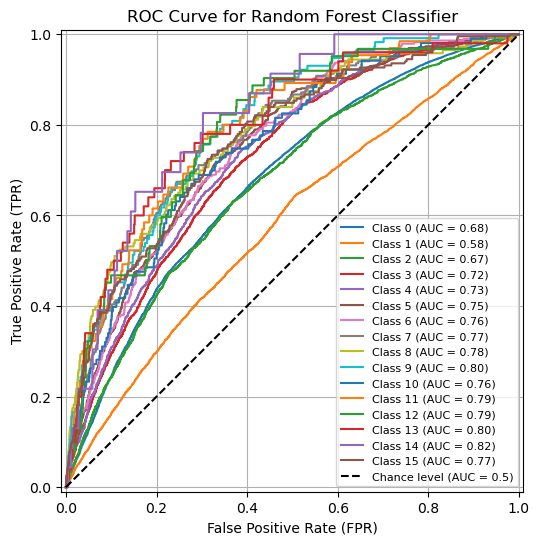

In [53]:
true_binary_labels = label_binarize(Y_test, classes=np.unique(Y_test))

fig_roc, ax_roc = plt.subplots(figsize=(6, 6))

# Plot ROC curve for each class
for i in range(np.unique(Y_test).size):
    display = RocCurveDisplay.from_predictions(
        true_binary_labels[:, i],
        pred_proba[:, i], 
        ax=ax_roc, 
        name=f"Class {i}",
        plot_chance_level=(i == np.unique(Y_test).size - 1)
    )

_ = ax_roc.set(
    xlabel='False Positive Rate (FPR)',
    ylabel='True Positive Rate (TPR)',
    title='ROC Curve for Random Forest Classifier'
)

plt.grid()
plt.legend(fontsize='8', loc='lower right')
plt.show()

### **Precision-Recall Curves**

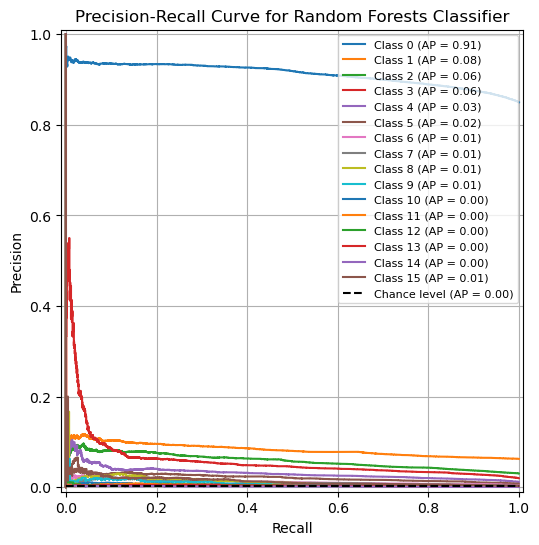

In [54]:
fig_prc, ax_prc = plt.subplots(figsize=(6, 6))

# Plot Precision-Recall curve for each class
for i in range(np.unique(Y_test).size):
    display = PrecisionRecallDisplay.from_predictions(
        true_binary_labels[:, i],
        pred_proba[:, i], 
        ax=ax_prc, 
        name=f"Class {i}",
        plot_chance_level=(i == np.unique(Y_test).size - 1)
    )

_ = ax_prc.set(
    xlabel='Recall',
    ylabel='Precision',
    title='Precision-Recall Curve for Random Forests Classifier'
)

plt.legend(fontsize='8', loc='upper right')
plt.grid()
plt.show()